In [1]:
import numpy as np
import proplot as plot
import pyart
import os

from unravel import dealias
import openradartools as ort


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/g/data/en0/jss548/miniconda3/envs/openradar/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
out_dirr = '/scratch/kl02/tmp/20230724_CASCV_subset_KDP'
dirr = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset/'
fns = sorted(os.listdir(dirr))
print(fns)

['2023072422_24_ODIMH5_PVOL6S_VOL_CASCV.h5', '2023072422_30_ODIMH5_PVOL6S_VOL_CASCV.h5', '2023072422_36_ODIMH5_PVOL6S_VOL_CASCV.h5', '2023072422_42_ODIMH5_PVOL6S_VOL_CASCV.h5', '2023072422_48_ODIMH5_PVOL6S_VOL_CASCV.h5', '2023072422_54_ODIMH5_PVOL6S_VOL_CASCV.h5', '2023072423_00_ODIMH5_PVOL6S_VOL_CASCV.h5']


/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset//2023072422_48_ODIMH5_PVOL6S_VOL_CASCV.h5
[(24.4, 31.746000289916992), (20.2, 31.746000289916992), (16.6, 31.746000289916992), (13.7, 31.746000289916992), (11.3, 31.746000289916992), (9.4, 31.746000289916992), (7.7, 23.809499740600586), (6.4, 23.809499740600586), (5.3, 16.402099609375), (4.4, 16.402099609375), (3.5, 16.402099609375), (2.7, 47.61899948120117), (2.1, 47.61899948120117), (1.6, 47.61899948120117), (1.2, 47.61899948120117), (0.8, 47.61899948120117), (0.4, 47.61899948120117)]


/g/data/en0/jss548/miniconda3/envs/openradar/lib/python3.8/site-packages/matplotlib_inline/config.py:59: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


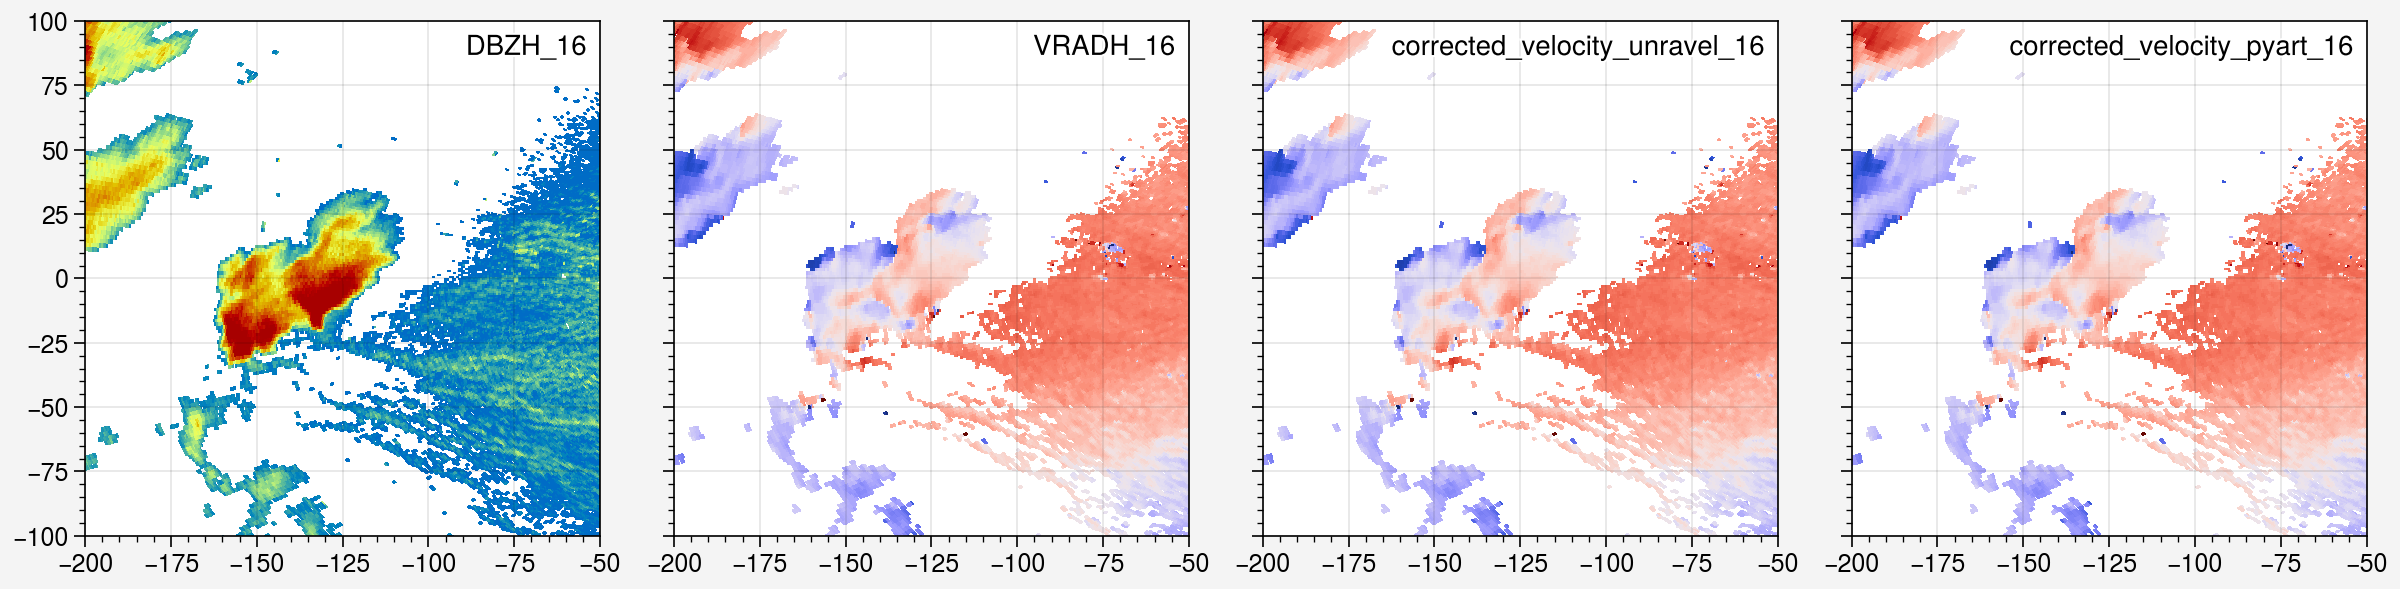

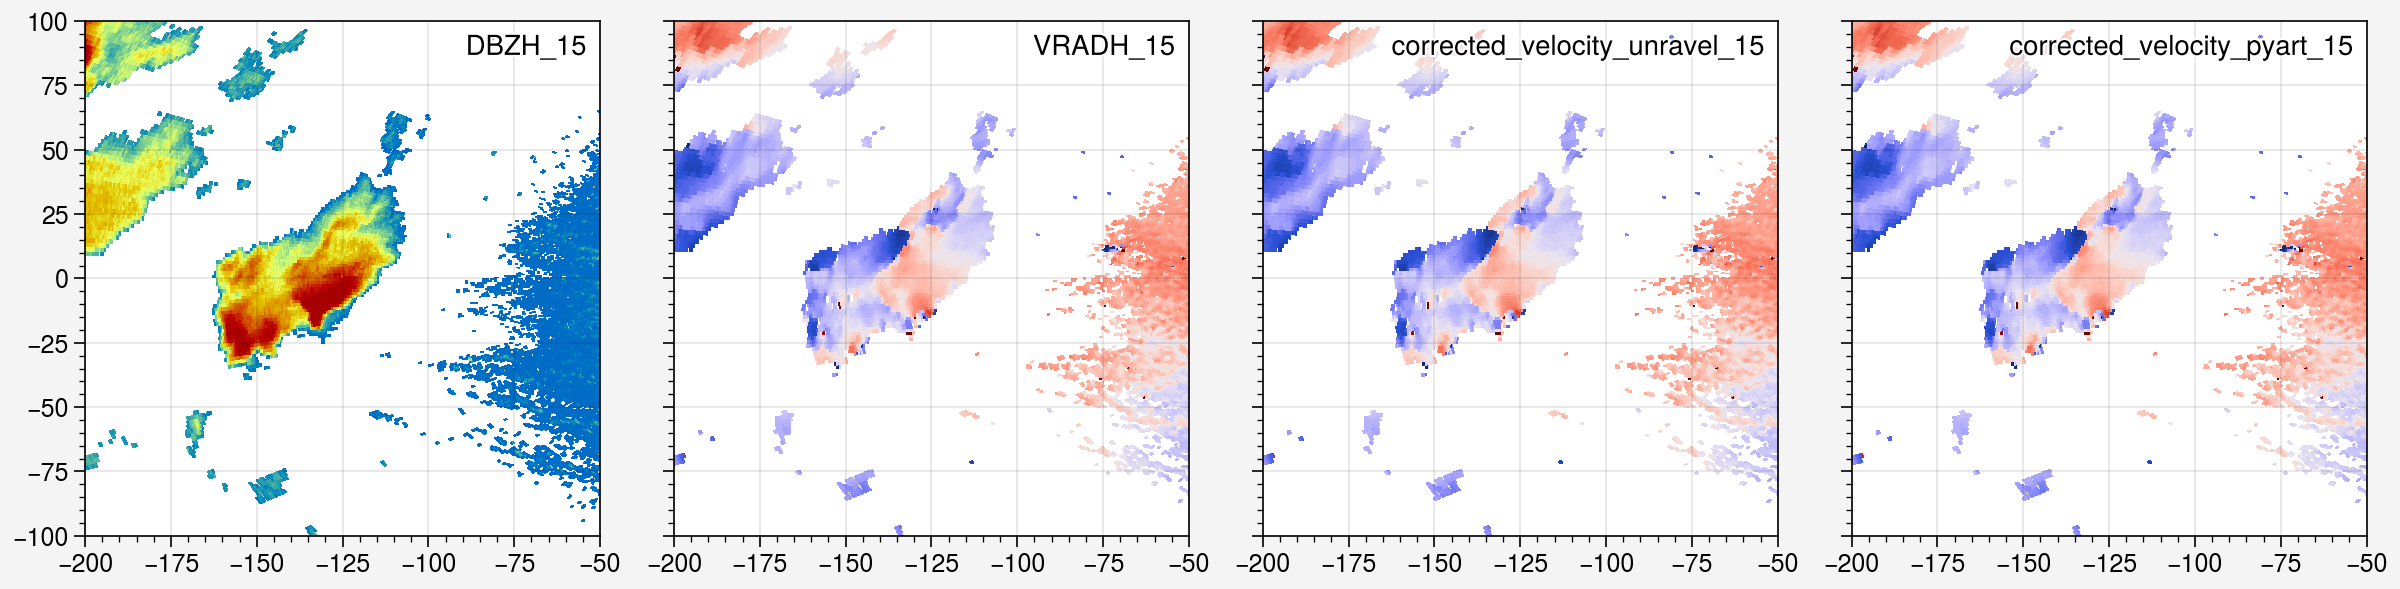

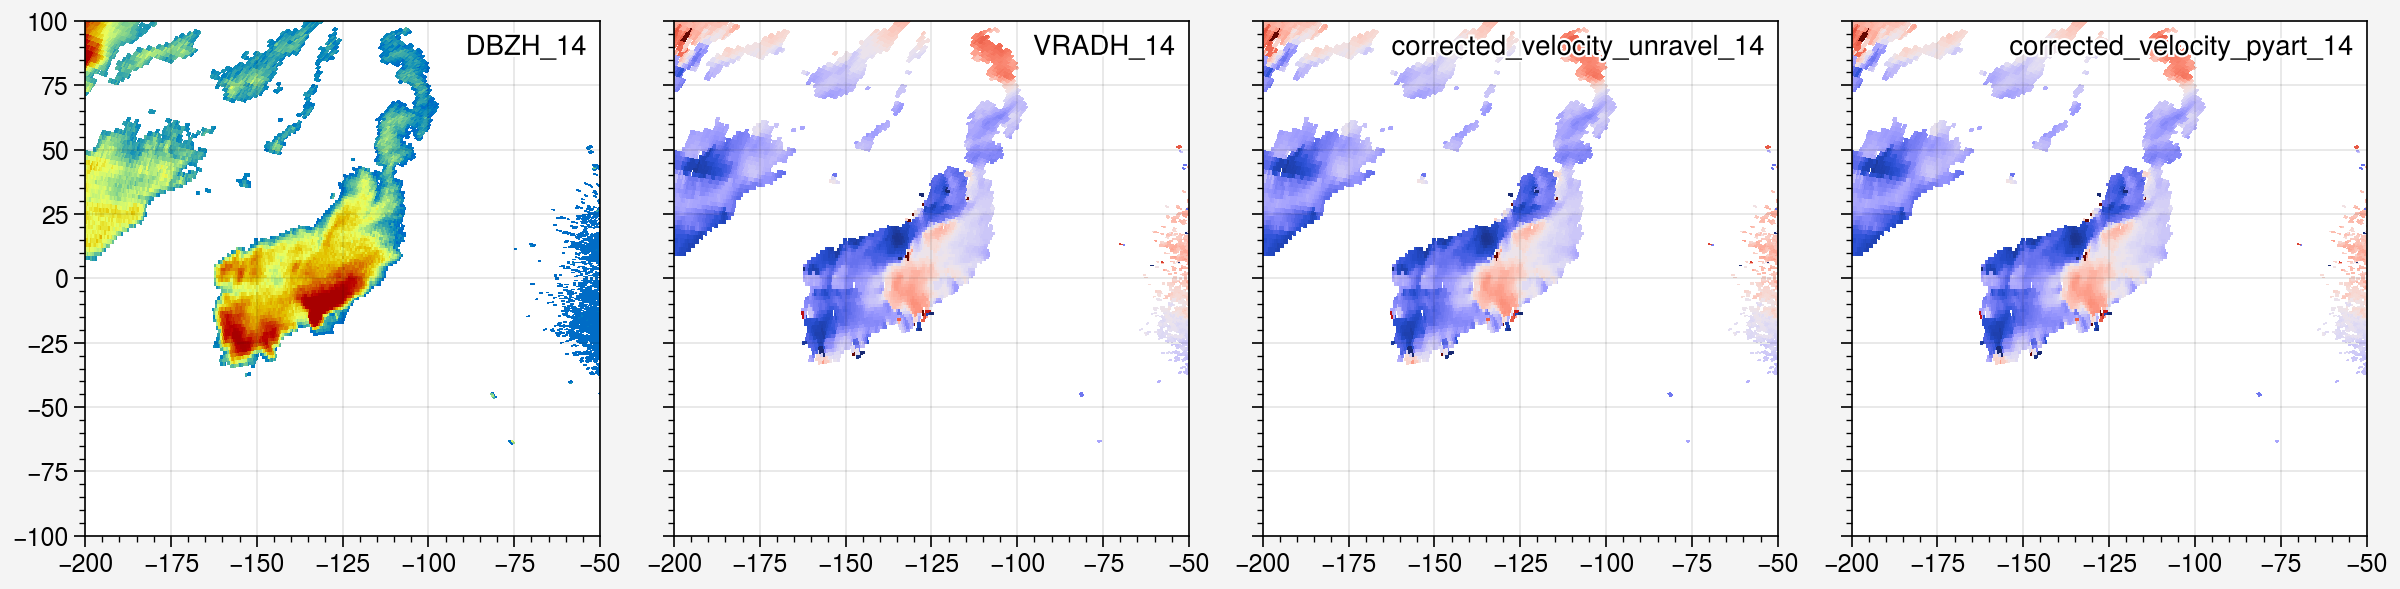

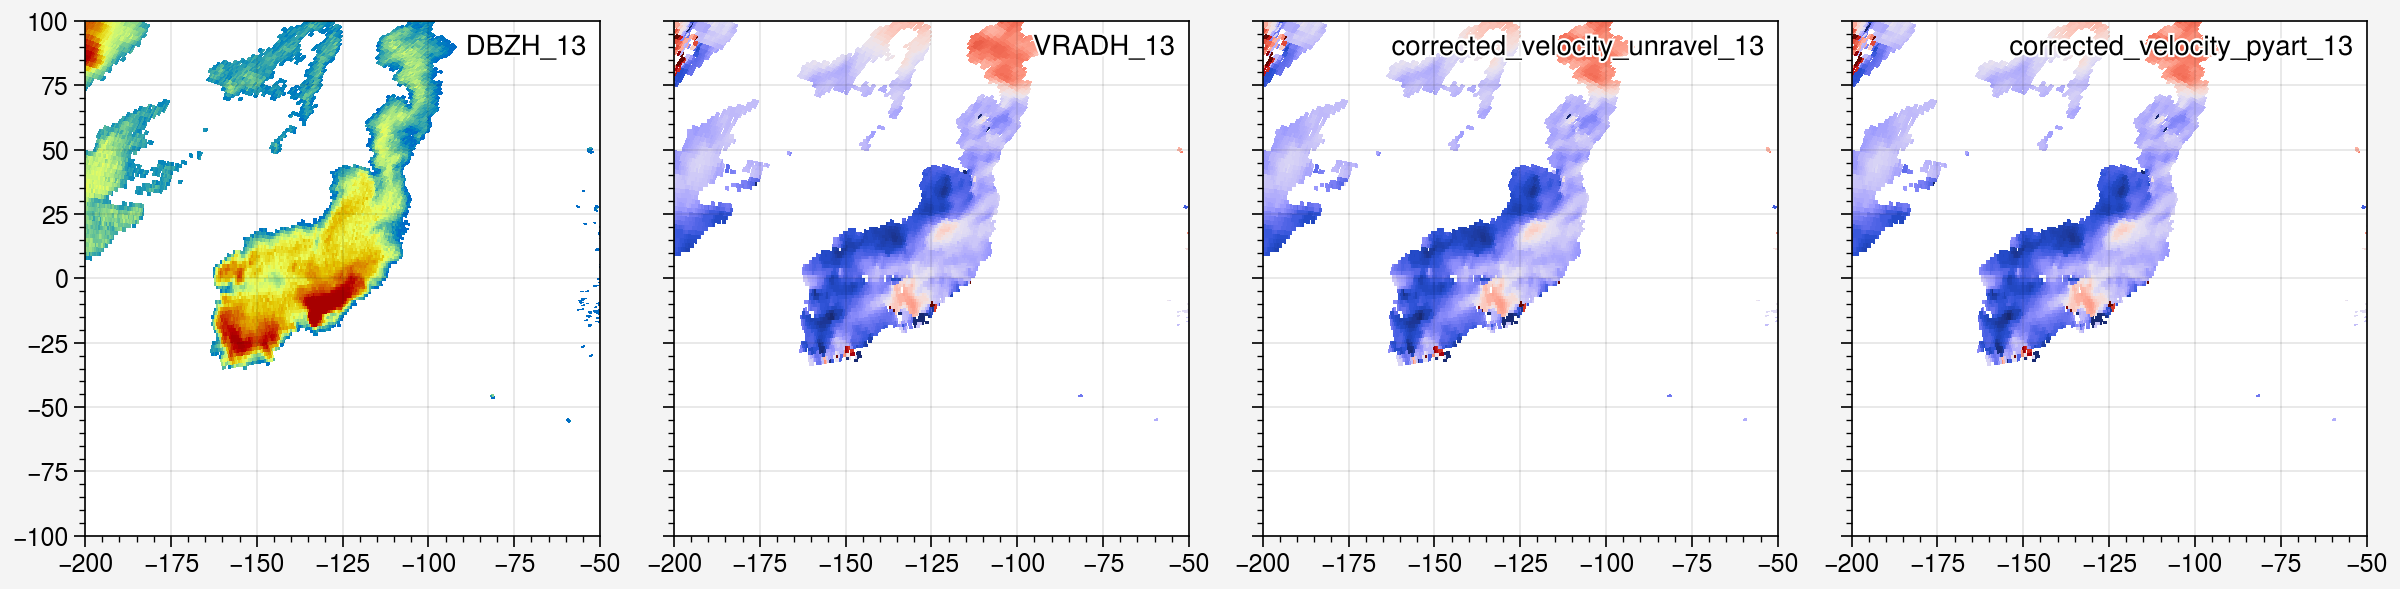

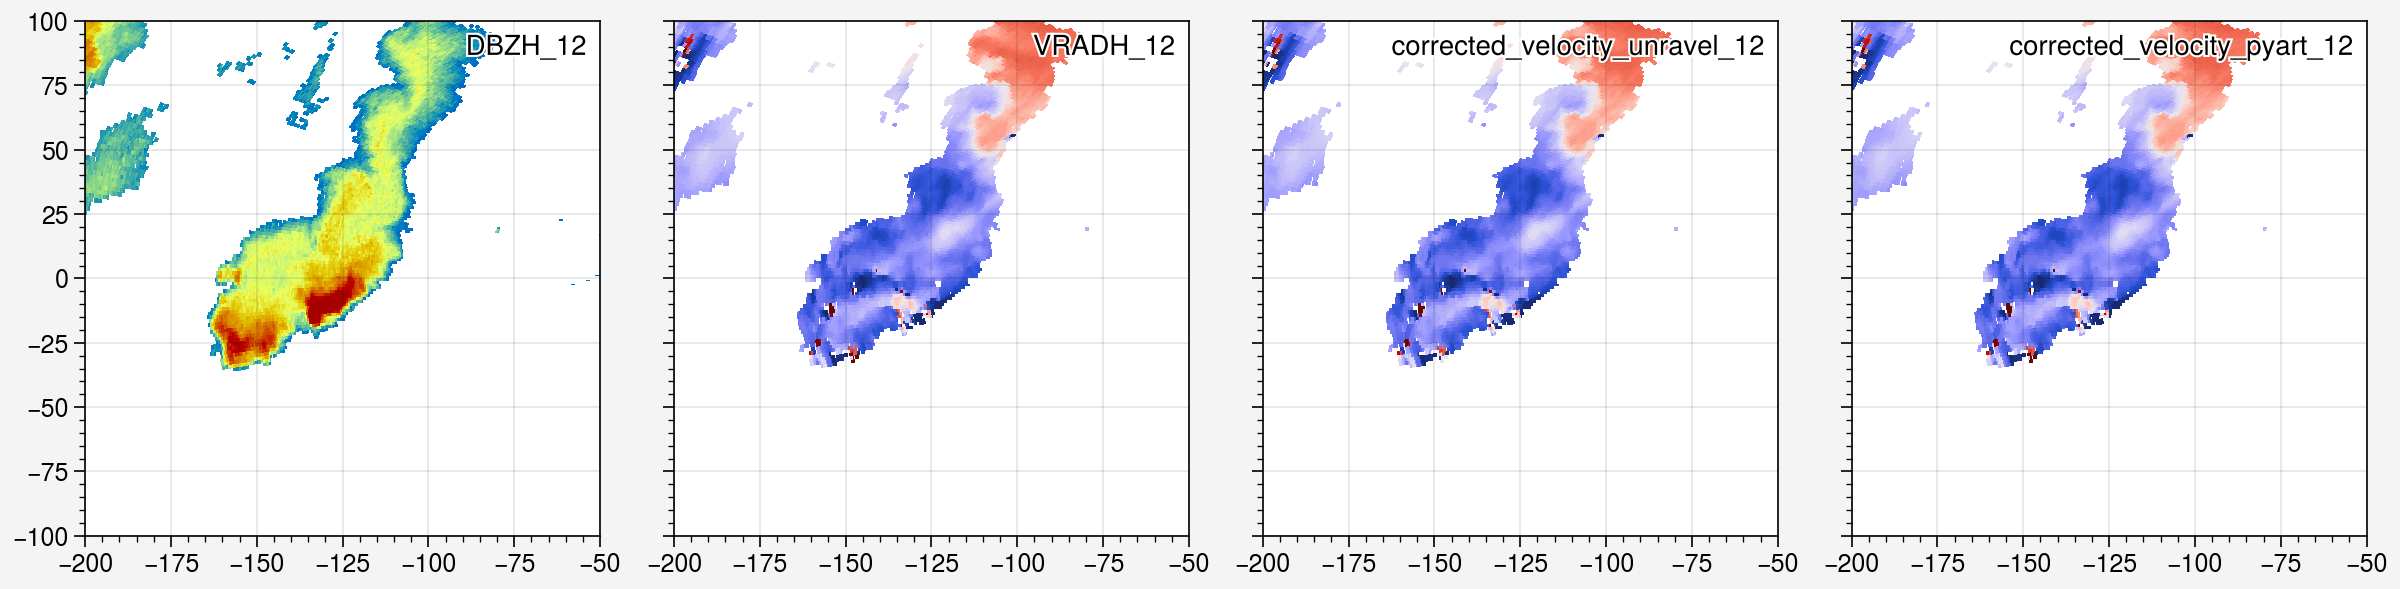

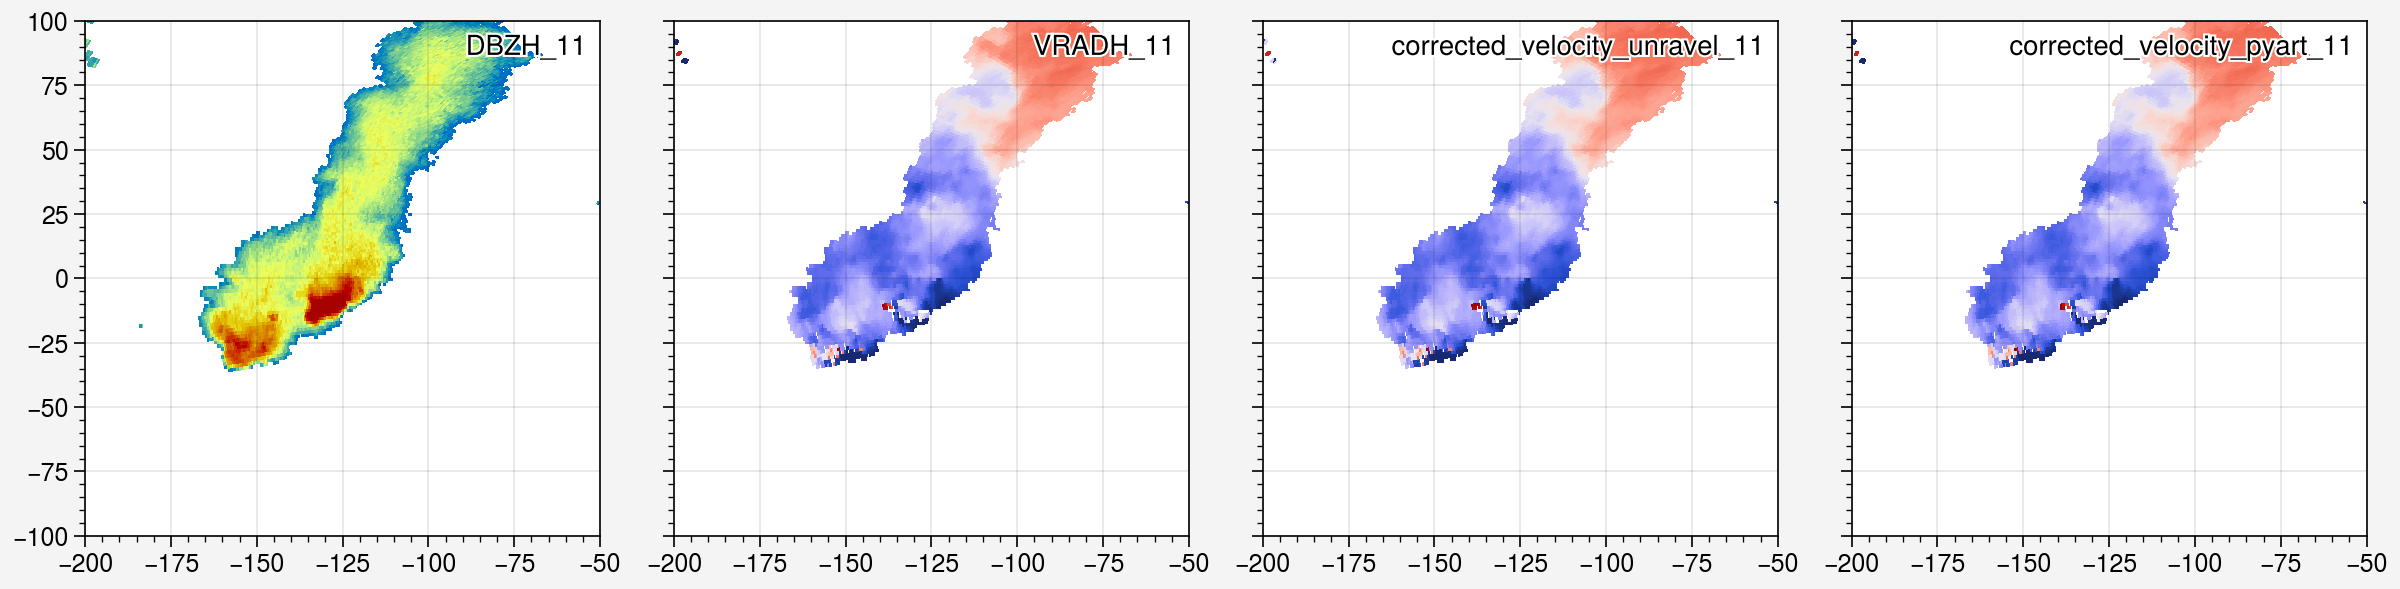

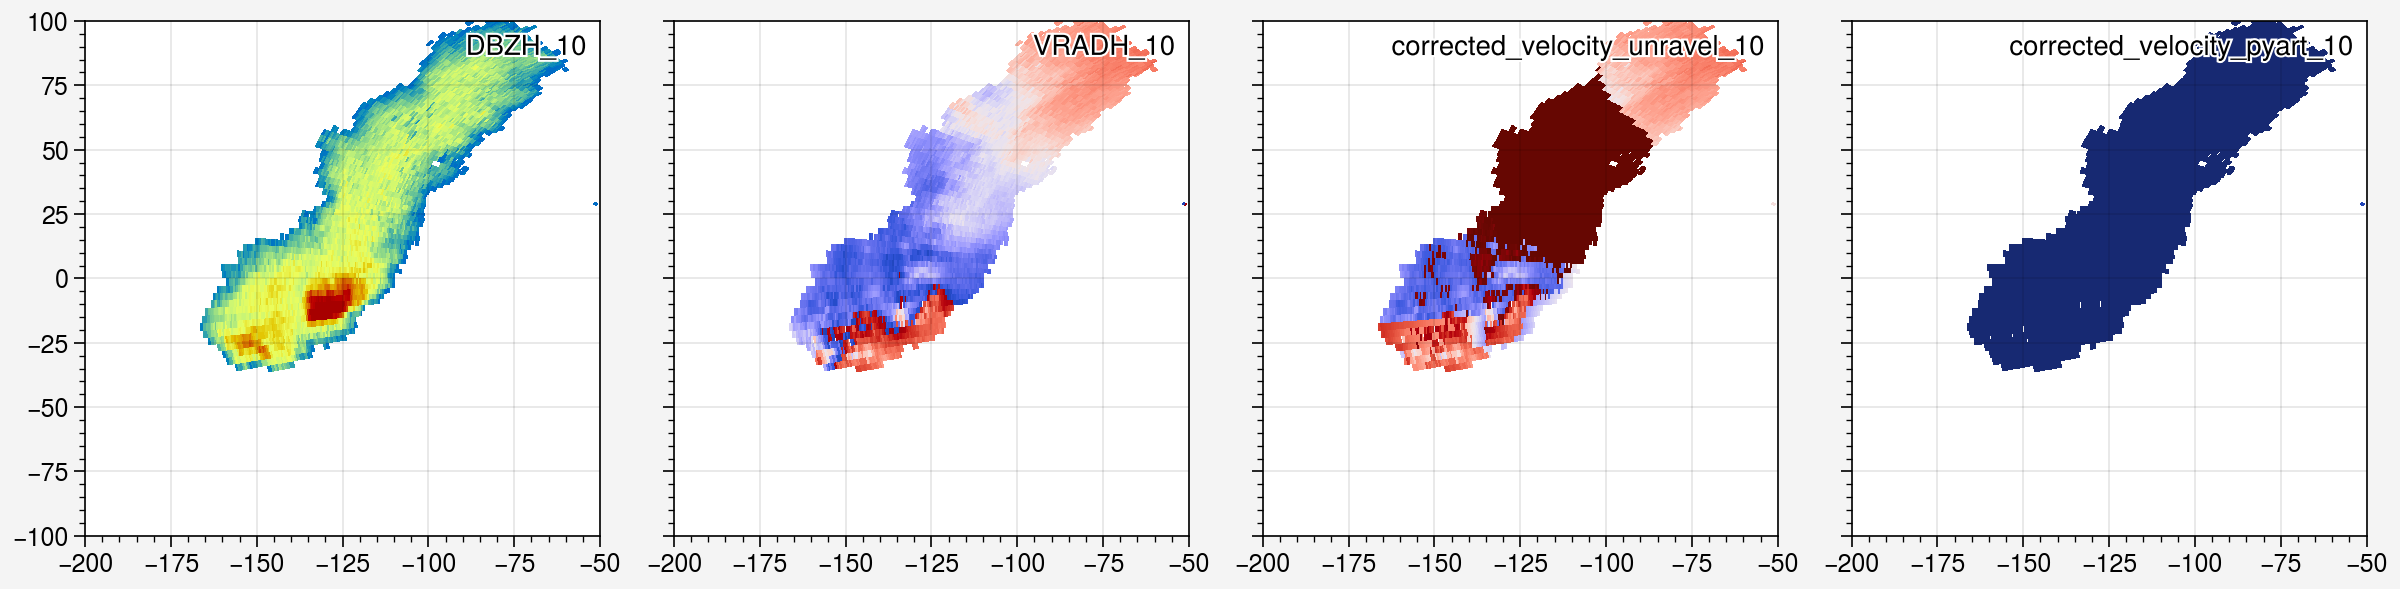

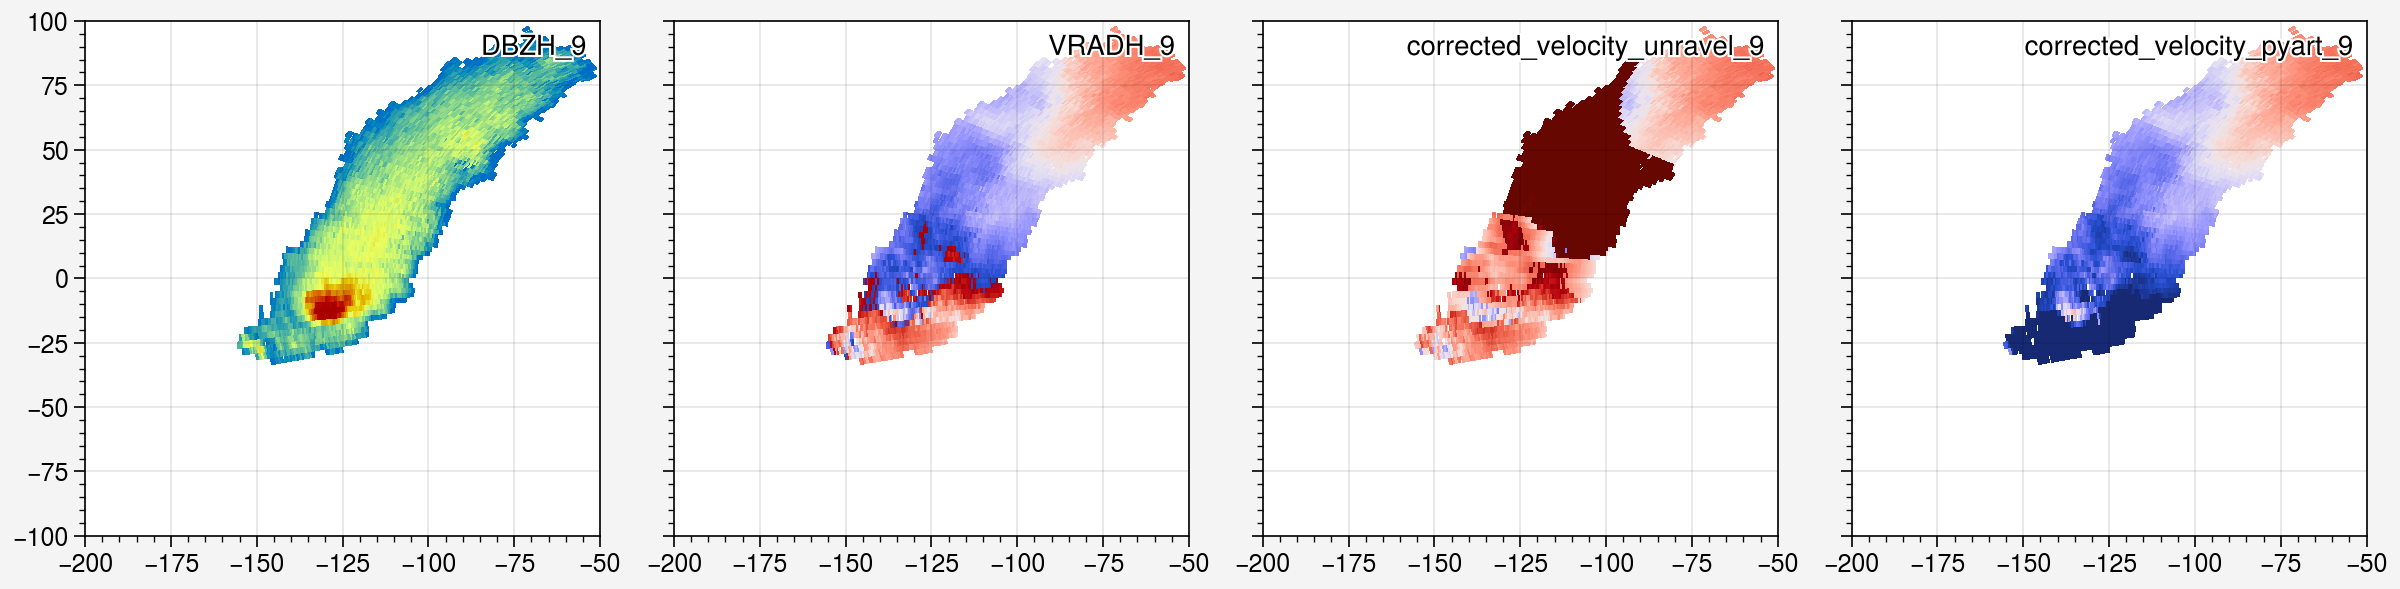

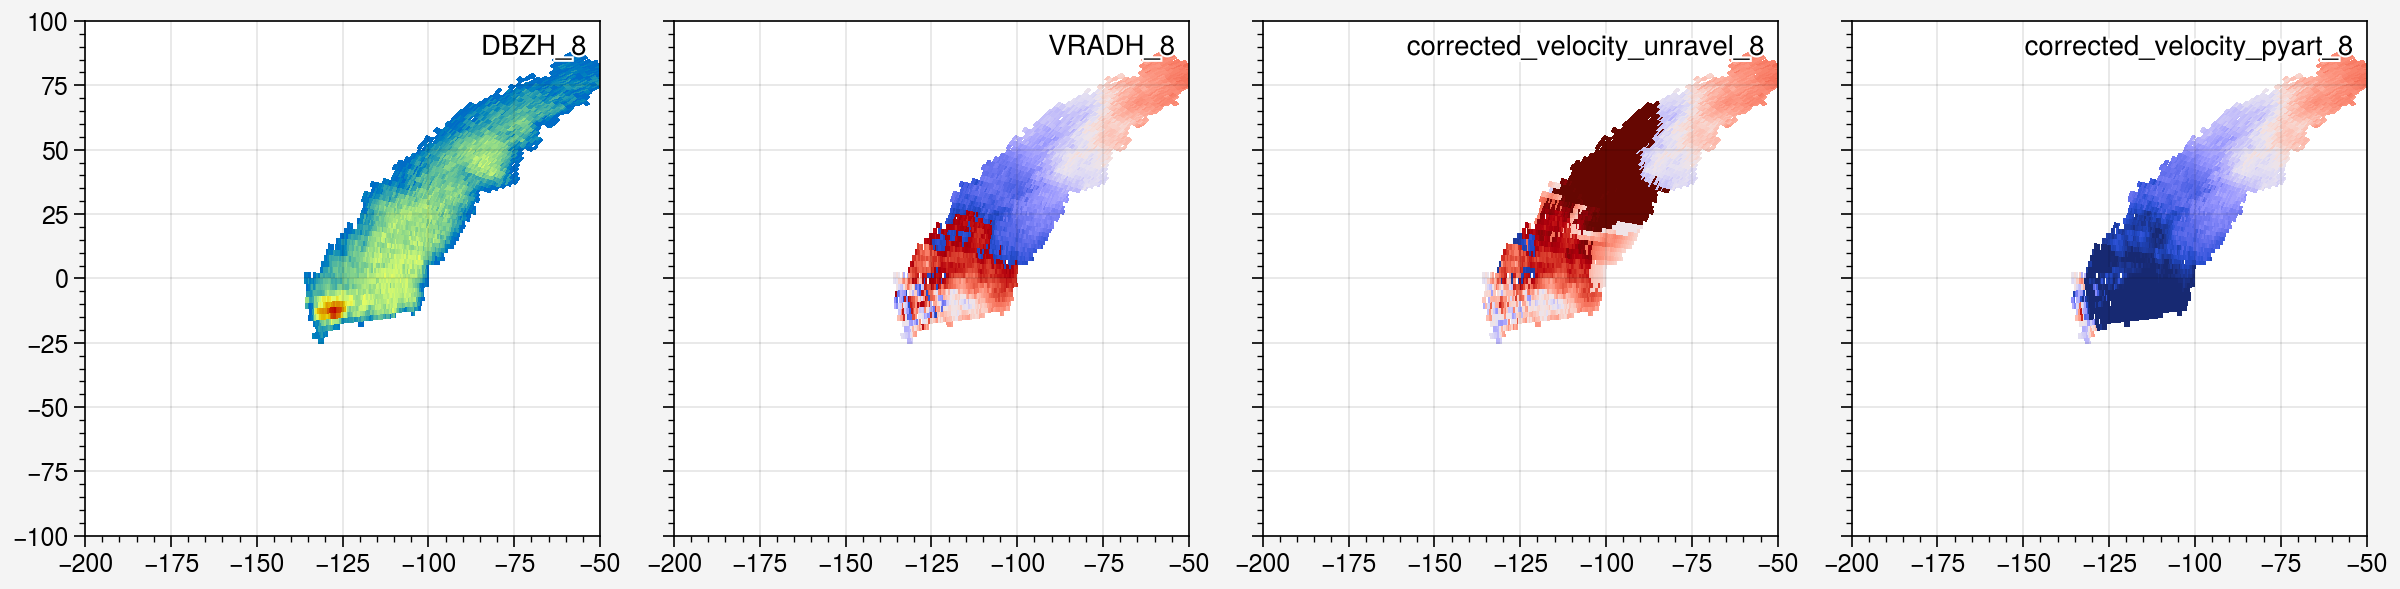

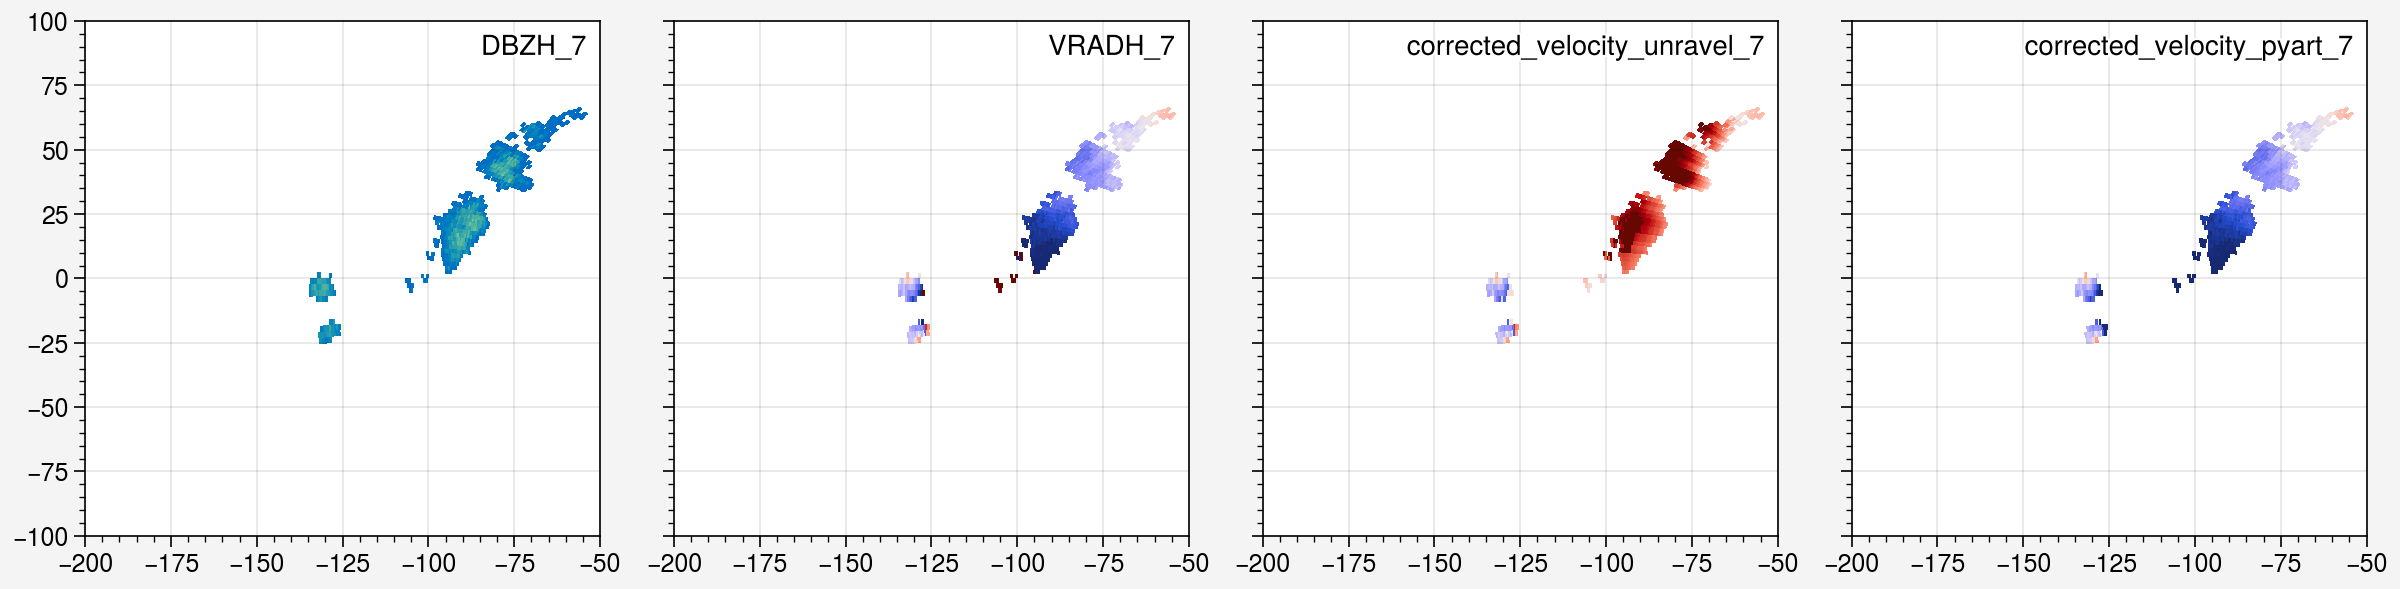

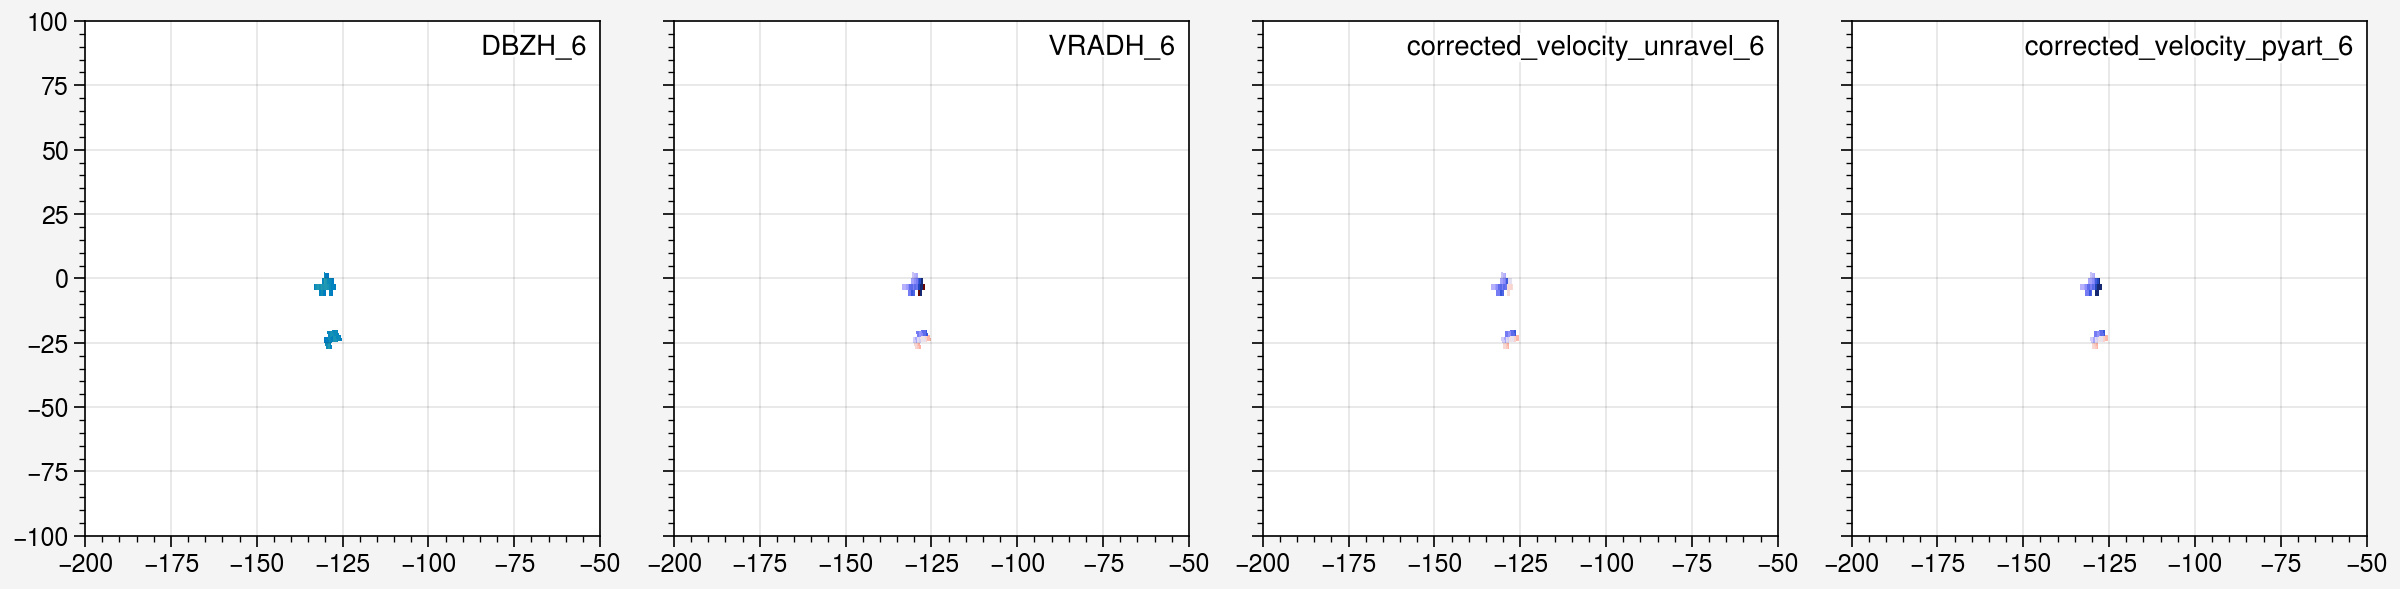

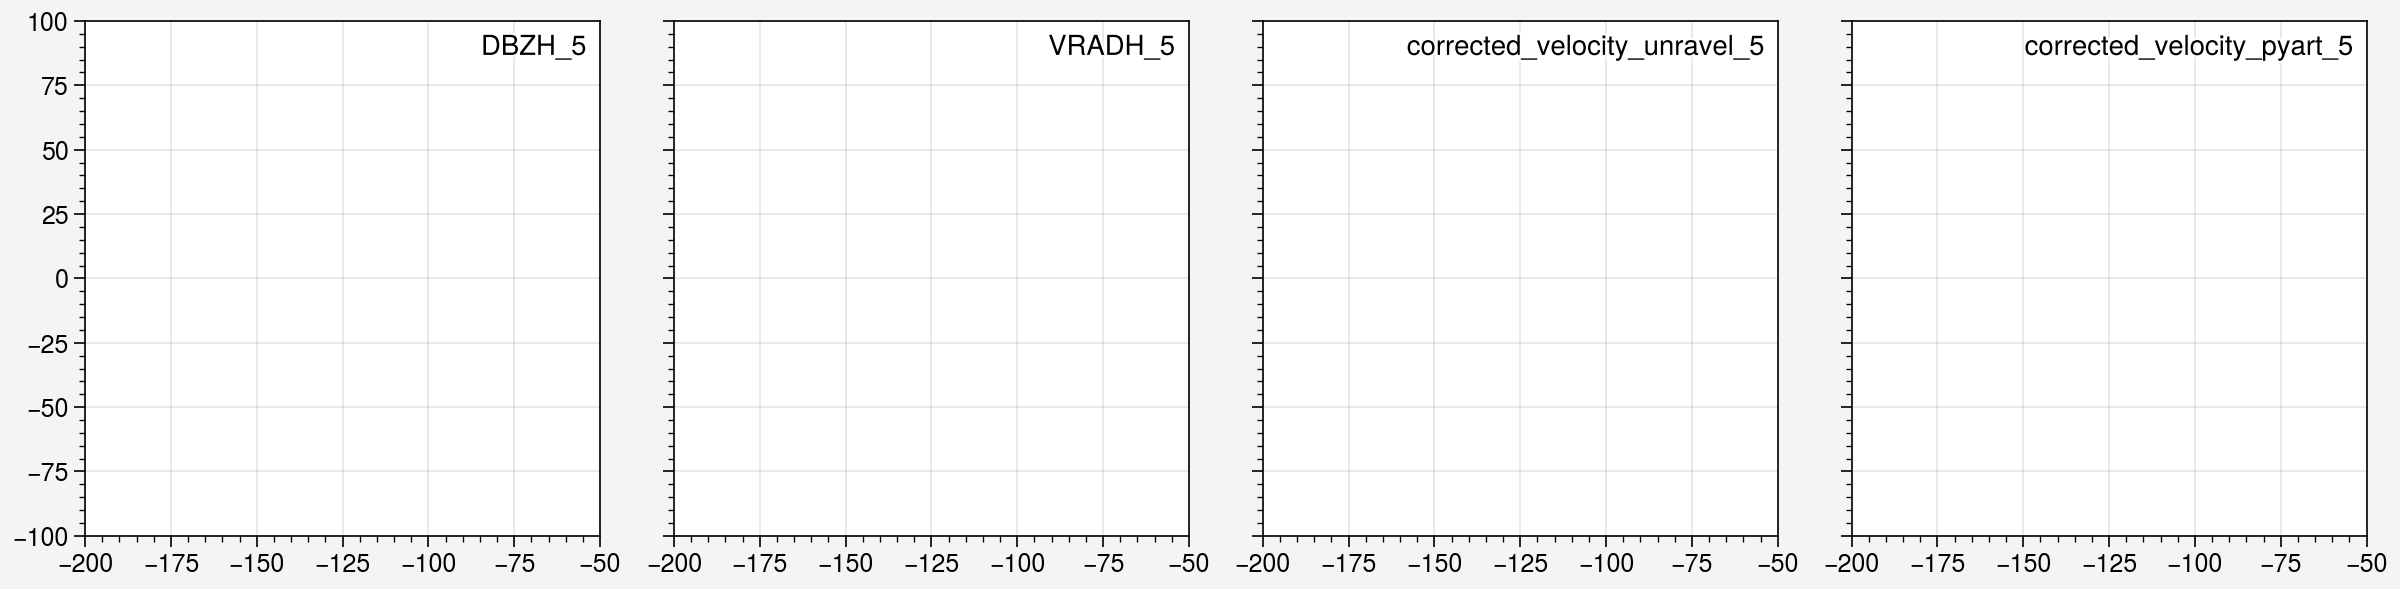

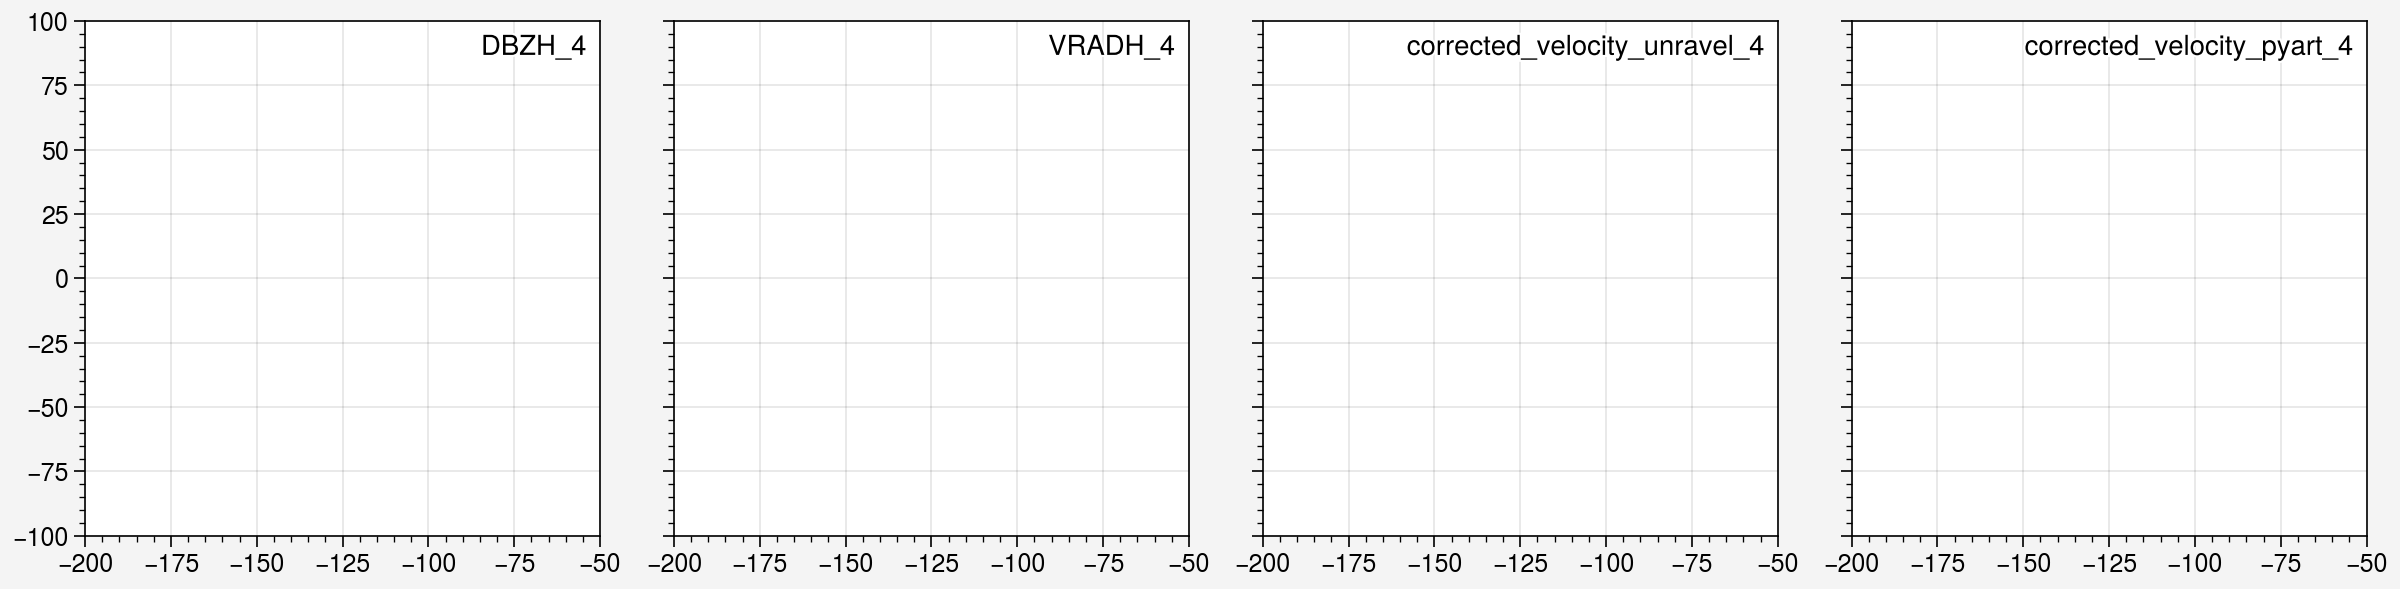

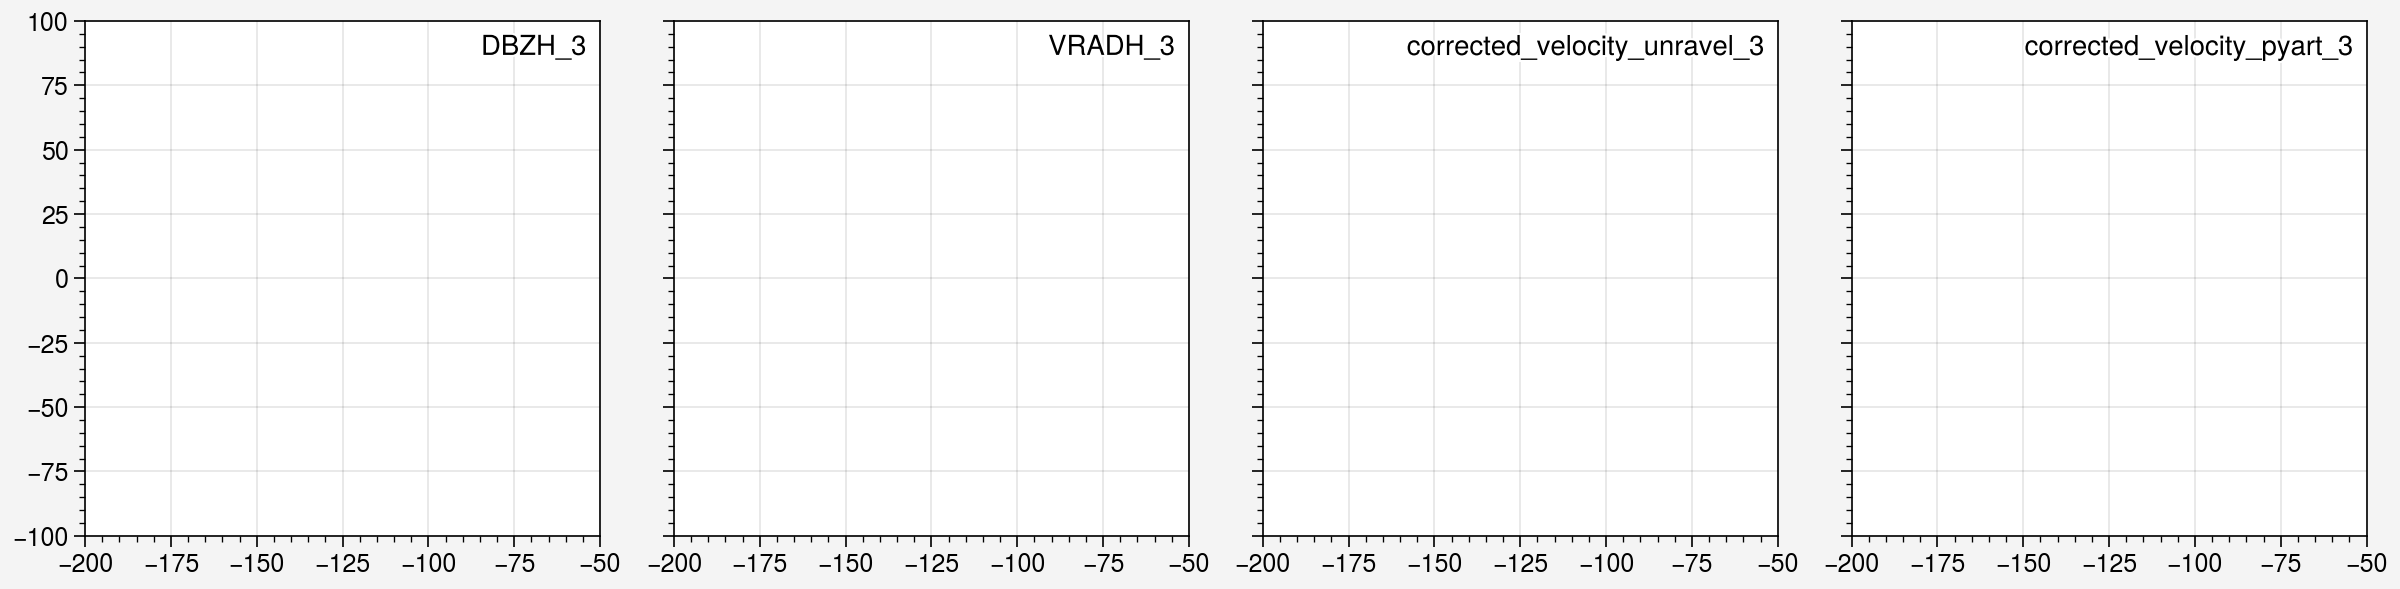

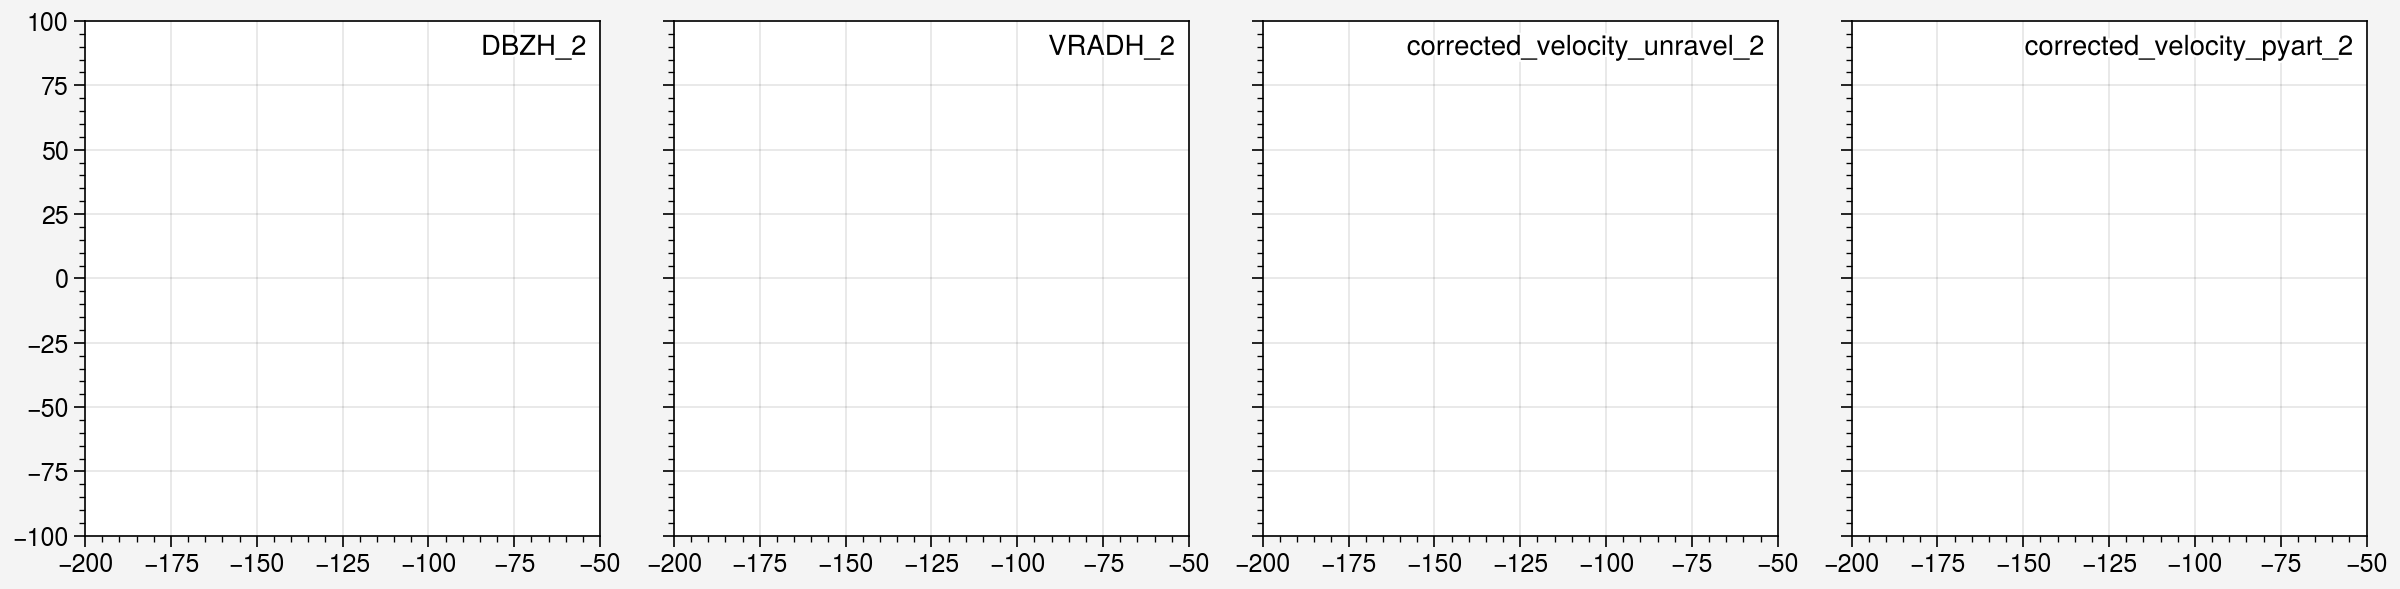

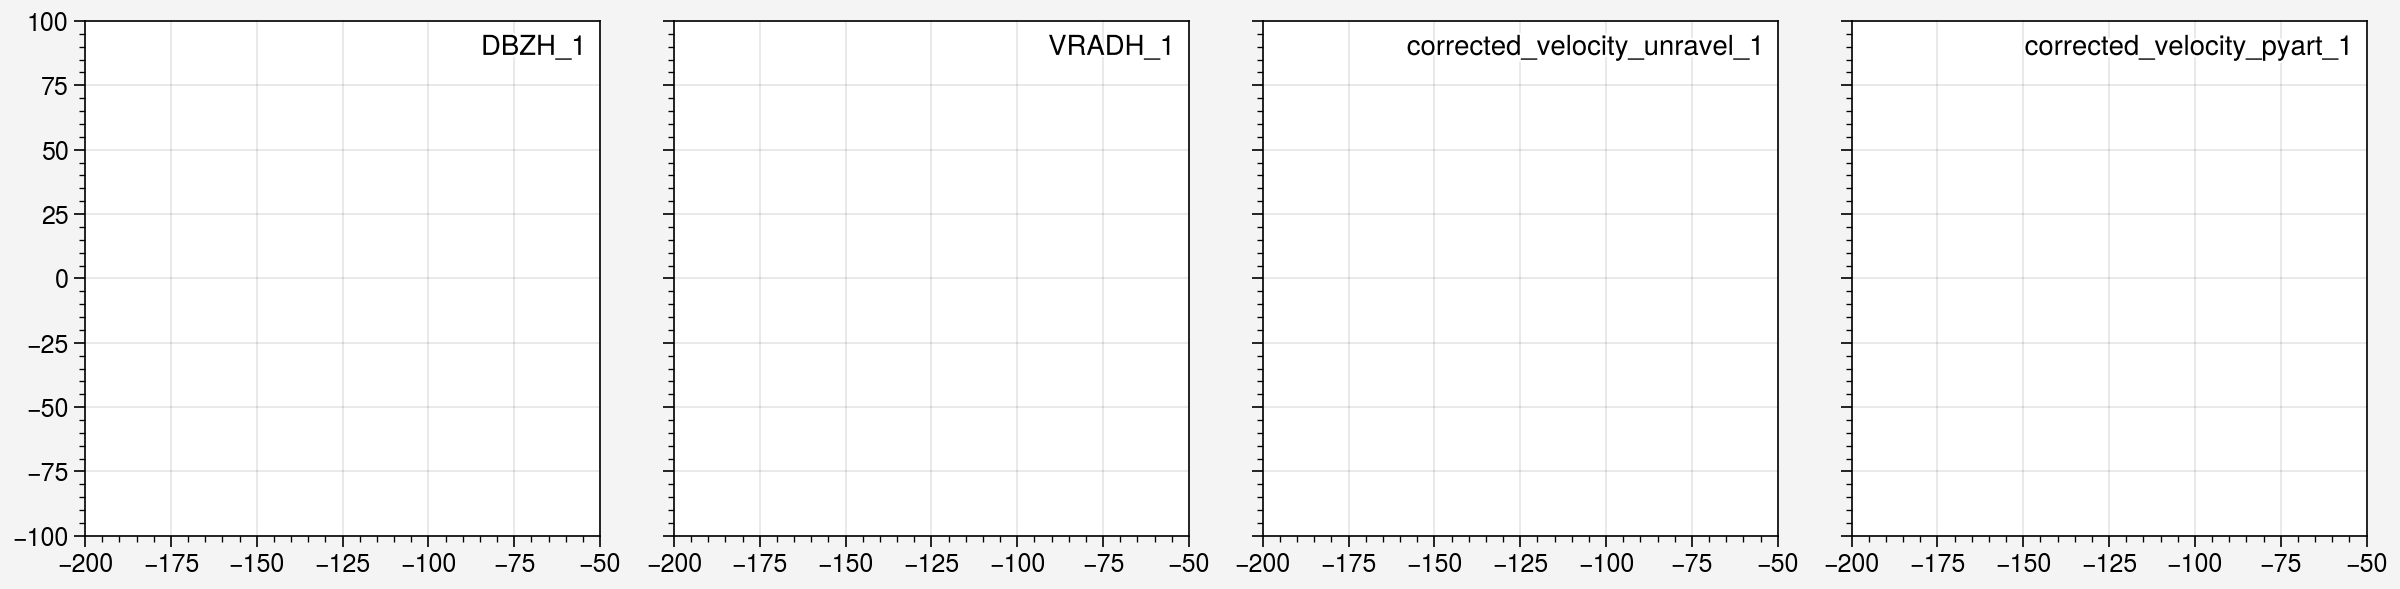

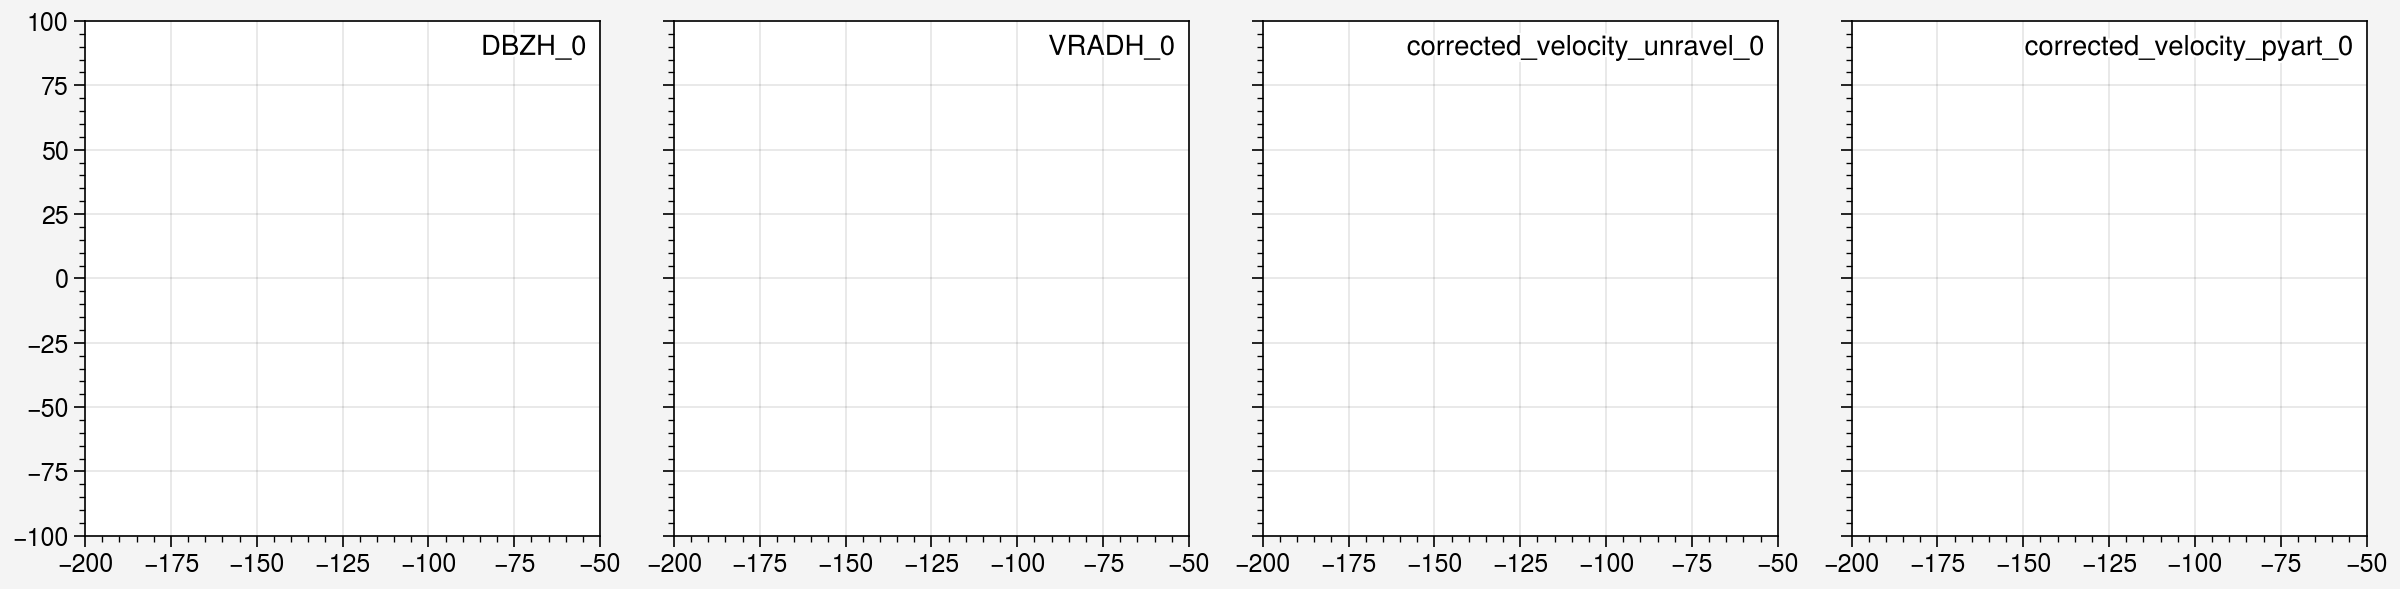

In [3]:
for fn in fns[4:5]:
    odim_ffn = f'{dirr}/{fn}'
    print(odim_ffn)
    radar = pyart.aux_io.read_odim_h5(odim_ffn, file_field_names=True)
    #field names
    dbz_field = 'DBZH'
    vrad_unravel_field = 'corrected_velocity_unravel'
    vrad_pyart_field = 'corrected_velocity_pyart'
    vrad_field = 'VRADH'


    #run region based
    nyquist_list = ort.vel.extract_nyquist(radar, odim_ffn)  # returns empty list if something fails
    print(list(zip(radar.fixed_angle['data'],nyquist_list)))
    corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vrad_field, nyquist_vel=nyquist_list)
    radar.add_field(vrad_pyart_field, corr_vel, replace_existing=True)

    #run unravel based
    gatefilter = pyart.correct.GateFilter(radar)
    vdop_unfold = dealias.unravel_3D_pyart(
        radar, vrad_field, dbz_field,
        gatefilter=gatefilter,
        nyquist_velocity=nyquist_list,
        strategy='long_range'
        
    )
    radar.add_field_like(vrad_field,vrad_unravel_field, vdop_unfold, replace_existing=True)


    kwargs = dict(vmin = 0, vmax = 1, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none')
    kwargs2 = dict(vmin = 0, vmax = 50, cmap = 'pyart_homeyerrainbow', discrete = False, edgecolor = 'none')
    kwargs3 = dict(vmin = 0.9, vmax = 1, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none')
    kwargs4 = dict(vmin = 20, vmax = 50, cmap = 'pyart_refdiff', discrete = False, edgecolor = 'none')
    kwargs5 = dict(vmin = -20, vmax = 20, cmap = 'BR', discrete = False, edgecolor = 'none')

    tilt = np.argmin(abs(radar.fixed_angle['data'] - 0))
    for tilt in range(radar.nsweeps)[::-1]:
        fig, axs = plot.subplots(width = 12, ncols = 4,  nrows = 1)
        xr, yr, zr = radar.get_gate_x_y_z(tilt)
        # axs[2].pcolormesh(xr/1e3, yr/1e3, radar.get_field(tilt, phidp_field), colorbar=  'b', **kwargs4)
        axs[0].pcolormesh(xr/1e3, yr/1e3, radar.get_field(tilt, dbz_field), **kwargs2)
        axs[1].pcolormesh(xr/1e3, yr/1e3, radar.get_field(tilt, vrad_field), **kwargs5)
        axs[2].pcolormesh(xr/1e3, yr/1e3, radar.get_field(tilt, vrad_unravel_field), **kwargs5)
        axs[3].pcolormesh(xr/1e3, yr/1e3, radar.get_field(tilt, vrad_pyart_field), **kwargs5)

        for i, label in enumerate([dbz_field, vrad_field, vrad_unravel_field, vrad_pyart_field]):
            axs[i].format(title = f'{label}_{tilt}', titleloc = 'ur')
        axs.format(xlim = [-200, -50], ylim = [-100, 100])
        plot.show()

In [36]:
radar.fields.keys()

dict_keys(['DBZH', 'VRADH', 'TH', 'RHOHV', 'UPHIDP', 'WRADH', 'PHIDP', 'ZDR', 'DR', 'KDP', 'SQIH'])

In [13]:
radar.instrument_parameters

In [32]:
radar.fields['velocity_horizontal']['data'][radar.get_slice(11)].max()

43.851963